# Aurora Forecasting - Part 04: Actionable Batch Inference

🗒️ This notebook is divided into the following sections:
Load the trained Kp prediction model from the Hopsworks Model Registry.

Retrieve the most recent solar wind features.

Predict the current Kp index.

Retrieve the latest cloud cover for Stockholm, Luleå, and Kiruna.

Apply city-specific logic to determine if an Aurora is truly visible.

In [1]:
import hopsworks
import joblib
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from config import HopsworksSettings
import util
import os

settings = HopsworksSettings()
project = hopsworks.login(
    project=settings.HOPSWORKS_PROJECT,
    api_key_value=settings.HOPSWORKS_API_KEY.get_secret_value()
)
fs = project.get_feature_store()
mr = project.get_model_registry()

2026-01-05 22:19:49,855 WARNING: UserWarning: Qin-Denton/OMNI2 data not found in current format. This module has limited functionality. Run spacepy.toolbox.update(QDomni=True) to download data.

HopsworksSettings initialized!
2026-01-05 22:19:49,862 INFO: Initializing external client
2026-01-05 22:19:49,863 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-05 22:19:50,580 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2026-01-05 22:19:52,051 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1299605


# Step 1: Load the Registered Model

We retrieve the latest version of our Random Forest model from the registry to make our geomagnetic predictions.

In [2]:
model_obj = mr.get_model(name=settings.MODEL_NAME, version=settings.MODEL_VERSION)
model_dir = model_obj.download()
model = joblib.load(os.path.join(model_dir, "model.pkl"))
print(f"Successfully loaded {settings.MODEL_NAME} version {model_obj.version} ")

Downloading: 0.000%|          | 0/2100779 elapsed<00:00 remaining<?

Successfully loaded aurora_kp_rf_model version 7 ONE


# Step 2: Retrieve Latest Features and Predict Kp

We fetch the most recent minute-by-minute data from NOAA. In a production environment, you would typically pull the latest data from the Online Feature Store.

In [ ]:
# We pull the most recent hours to show a trend on our dashboard
# OLD BUT NOT WORK BECAUSE VERSION 5 IS CREATED AND UPDATE BY NOTEBOOK 3 THAT IS NOT RUNNED DAILY
#solar_wind_fg = fs.get_feature_group(name="aurora_solarwind_features", version=5)

#NEW ATTEMPT BY ALE
#take version 2
solar_wind_fg = fs.get_feature_group(name="solar_wind_fg", version=2)

#engineeer the version 5 like in notebook 3
print("Fetching fresh data from Feature Store...")

# Pulling last 24 records to generate a trend graph
recent_data = solar_wind_fg.read()
recent_data['date_and_time'] = pd.to_datetime(recent_data['date_and_time'])
recent_data=recent_data.sort_values(by='date_and_time')
print(f"Raw data fetched: {len(recent_data)} rows. Most recent: {recent_data['date_and_time'].iloc[-1]}")
print(recent_data.tail(24))





Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (7.16s) 
                  date_and_time    by_gsm    bz_gsm   density       speed  \
2258  2025-12-09 22:00:00+00:00 -1.400000 -2.200000  3.800000  347.000000   
1483  2025-12-09 23:00:00+00:00 -2.000000 -2.100000  4.000000  345.000000   
6071  2025-12-10 00:00:00+00:00 -0.900000 -2.200000  2.900000  335.000000   
6069  2025-12-10 01:00:00+00:00 -2.000000 -2.200000  3.000000  331.000000   
7655  2026-01-04 14:00:00+00:00 -5.493846  1.534615  0.125000  449.731262   
10592 2026-01-04 15:00:00+00:00 -5.469189  2.812433  3.317255  447.294128   
12162 2026-01-04 16:00:00+00:00 -2.213256  2.457442  0.177959  450.263275   
10400 2026-01-04 17:00:00+00:00 -1.449792 -0.416250  0.301489  451.046814   
15229 2026-01-04 18:00:00+00:00  0.054912 -3.113509  0.284400  450.325989   
1541  2026-01-04 19:00:00+00:00 -1.798431 -2.726863  0.330000  444.833344   
5575  2026-01-04 20:00:00+00:00 -5.528409 -2.747727  0.805818  449.

In [ ]:
# ---------------------------------------------------------
# FEATURE ENGINEERING (Must match Notebook 3 exactly)
# ---------------------------------------------------------
# A. Create Lags
LAGS = [1, 2, 3, 4]
for col in ['by_gsm', 'bz_gsm', 'density', 'speed']:
    for lag in LAGS:
        recent_data[f"{col}_lag_{lag}"] = recent_data[col].shift(lag)

# B. Create Rolling Statistics
WINDOWS = [2, 4]
for col in ['bz_gsm', 'speed', 'density']:
    for w in WINDOWS:
        recent_data[f"{col}_roll_mean_{w}"] = recent_data[col].rolling(w).mean()
        recent_data[f"{col}_roll_std_{w}"] = recent_data[col].rolling(w).std()

# C. Create Dynamic Pressure
# Formula: density * speed^2 (simplified representation used in training)
recent_data['dynamic_pressure'] = recent_data['density'] * (recent_data['speed'] ** 2)

# D. Cleanup
# The first few rows will contain NaNs due to shifting/rolling.
# We drop them to ensure clean input for the model.
df_clean = recent_data.dropna().copy()

print(f"Data processed. Available for inference: {len(df_clean)} rows.")

In [ ]:
latest_record = df_clean.iloc[[-1]] # Double brackets keeps it as a DataFrame
latest_time = latest_record['date_and_time'].values[0]

print(f"Performing inference for time: {latest_time}")

# 2. Prepare Feature Vector (Drop non-feature columns)
# The model expects only specific columns. We must drop ID/Target columns.
features_df = latest_record.drop(columns=['date_and_time', 'kp_index'], errors='ignore')

# 3. Predict
predicted_kp = model.predict(features_df)[0]

print(f"✅ PREDICTED Kp INDEX: {predicted_kp:.2f}")

DA QUI COMMENTO UN ATTIMO

In [ ]:
# Prepare features for the model (ensuring they match the training columns)
# Drop 'time' and the target 'kp_index' to isolate features

#features_df = recent_data.drop(columns=['date_and_time', 'kp_index'], errors='ignore')

In [ ]:
# 4. Predict Kp Index for the whole window
#recent_data['predicted_kp'] = model.predict(features_df)
#latest_prediction = recent_data.iloc[-1]
#predicted_kp = latest_prediction['predicted_kp']

#print(f"\n>>> Current Predicted Global Kp Index: {predicted_kp:.2f}")


>>> Current Predicted Global Kp Index: 3.00


FINE PARTE COMMENTATA

In [ ]:
# 5. Local Visibility and Actionable Decisions
results = []
current_time = datetime.datetime.now()

for city, city_conf in settings.CITIES.items():
    cloud_cover = util.get_city_weather_forecast(city_conf['lat'], city_conf['lon'])
    status = util.aurora_visibility_logic(
        pred_kp=predicted_kp,
        kp_threshold=city_conf['kp_threshold'],
        cloud_cover=cloud_cover
    )
    
    results.append({
        "City": city,
        "date_and_time": current_time,
        "predicted_kp": round(predicted_kp, 2),
        "Cloud_cover": cloud_cover,
        "Status": status
    })

inference_df = pd.DataFrame(results)
print("\n--- Current Visibility Status ---")
print(inference_df[['city', 'predicted_kp', 'cloud_cover', 'status']])


--- Current Visibility Status ---
        city  predicted_kp  cloud_cover                  status
0     Kiruna           3.0            2                      GO
1      Luleå           3.0           97  HIGH ACTIVITY / CLOUDY
2  Stockholm           3.0          100             NO ACTIVITY


In [10]:
# 6. Update Monitoring Feature Group
monitor_fg = fs.get_or_create_feature_group(
    name="aurora_monitoring_fg",
    version=2,
    primary_key=['city', 'date_and_time'],
    event_time="date_and_time",
    description="Actual vs Predicted visibility signals for monitoring"
)
monitor_fg.insert(inference_df)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1299605/fs/1287235/fg/1908086


Uploading Dataframe: 100.00% |██████████| Rows 3/3 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aurora_monitoring_fg_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1299605/jobs/named/aurora_monitoring_fg_2_offline_fg_materialization/executions


(Job('aurora_monitoring_fg_2_offline_fg_materialization', 'SPARK'), None)

Dashboard


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.97s) 
2026-01-05 18:51:46,151 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.


Dashboard saved as aurora_dashboard.png


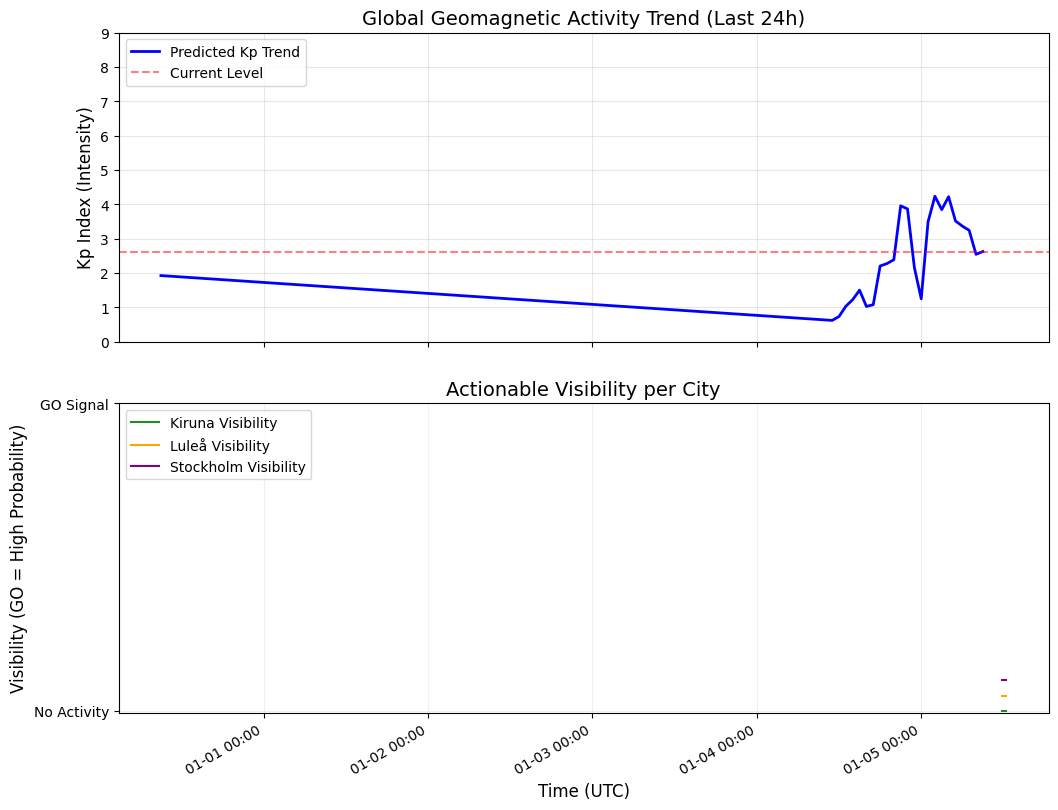

Uploading /Users/nico/Documents/GitHub/ID2223_Project/aurora_dashboard.png: 0.000%|          | 0/55708 elapsed…

KeyboardInterrupt: 

In [ ]:
# 7. VISUAL DASHBOARD GENERATION
# We pull the history of predictions to show the timeline
history_df = monitor_fg.read().sort_values(by='time')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot 1: Kp Index Trend
ax1.plot(recent_data['time'], recent_data['predicted_kp'], color='blue', linewidth=2, label='Predicted Kp Trend')
ax1.axhline(y=predicted_kp, color='red', linestyle='--', alpha=0.5, label='Current Level')
ax1.set_ylabel('Kp Index (Intensity)', fontsize=12)
ax1.set_ylim(0, 9)
ax1.set_title('Global Geomagnetic Activity Trend (Last 24h)', fontsize=14)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: City Visibility Timeline (The "Go" signal)
colors = {'Kiruna': 'forestgreen', 'Luleå': 'orange', 'Stockholm': 'purple'}
for i, city in enumerate(settings.CITIES.keys()):
    city_hist = history_df[history_df['city'] == city].tail(24).copy()
    # Map "GO" to 1, others to 0 for plotting
    city_hist['go_val'] = city_hist['status'].apply(lambda x: 1 if x == "GO" else 0)
    
    # Offset the city lines slightly so they are all visible
    ax2.step(city_hist['time'], city_hist['go_val'] + (i * 0.05), label=f'{city} Visibility', color=colors[city], where='post')

ax2.set_ylabel('Visibility (GO = High Probability)', fontsize=12)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['No Activity', 'GO Signal'])
ax2.set_title('Actionable Visibility per City', fontsize=14)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.2)

plt.xlabel('Time (UTC)', fontsize=12)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
fig.autofmt_xdate()

# Save the dashboard
dashboard_path = "aurora_dashboard.png"
plt.savefig(dashboard_path, bbox_inches='tight')
print(f"\nDashboard saved as {dashboard_path}")
plt.show()

# 8. Upload to Hopsworks Resources
dataset_api = project.get_dataset_api()
if not dataset_api.exists("Resources/aurora"):
    dataset_api.mkdir("Resources/aurora")

# Upload the latest dashboard for public viewing
dataset_api.upload(dashboard_path, "Resources/aurora/latest_dashboard.png", overwrite=True)
# Upload a timestamped version for history
timestamp = current_time.strftime('%Y%m%d_%H%M')
dataset_api.upload(dashboard_path, f"Resources/aurora/history/dashboard_{timestamp}.png", overwrite=True)

print(f"Dashboard uploaded to Hopsworks: Resources/aurora/latest_dashboard.png")

# Save the dashboard into the docs folder for GitHub Pages
dashboard_path = "docs/aurora/assets/img/latest_dashboard.png"
plt.savefig(dashboard_path, bbox_inches='tight')